/Users/Marc/Documents/GitHub/immo-eliza-lions/.venv/bin/python
2.3.0
✅ Data loaded. Rows: 58679, Columns: 16
Data Overview:
Rows: 58679
Columns: 16

Data types:
type                          int64
subtype                      object
bedroomCount                float64
bathroomCount               float64
province                     object
locality                     object
postCode                      int64
habitableSurface            float64
buildingCondition           float64
buildingConstructionYear    float64
facedeCount                 float64
toiletCount                 float64
epcScore                    float64
price                       float64
region                       object
price_per_m2                float64
dtype: object

Missing Values:
type                            0
subtype                         0
bedroomCount                 1452
bathroomCount                6139
province                        0
locality                        0
postCode                    

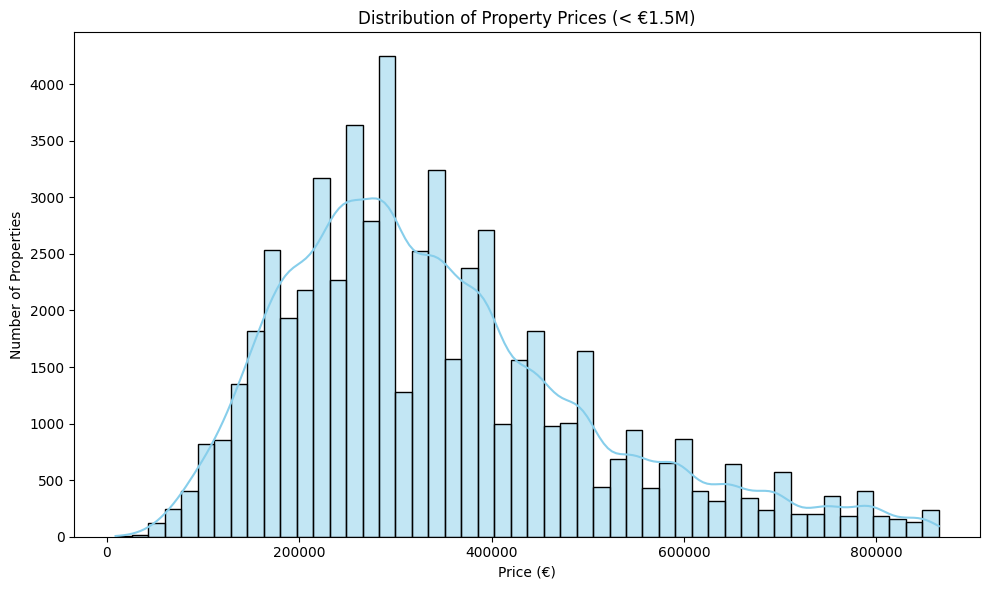

/var/folders/yp/grpj3l556fl4nly4zbgbvzb80000gn/T/ipykernel_95549/1833030899.py:73: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data, x='region', y='price_per_m2', palette='pastel')


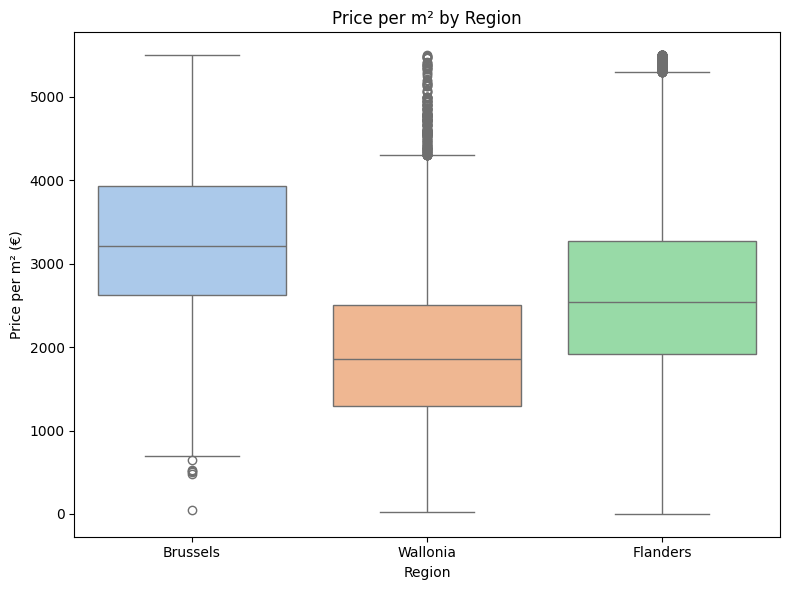

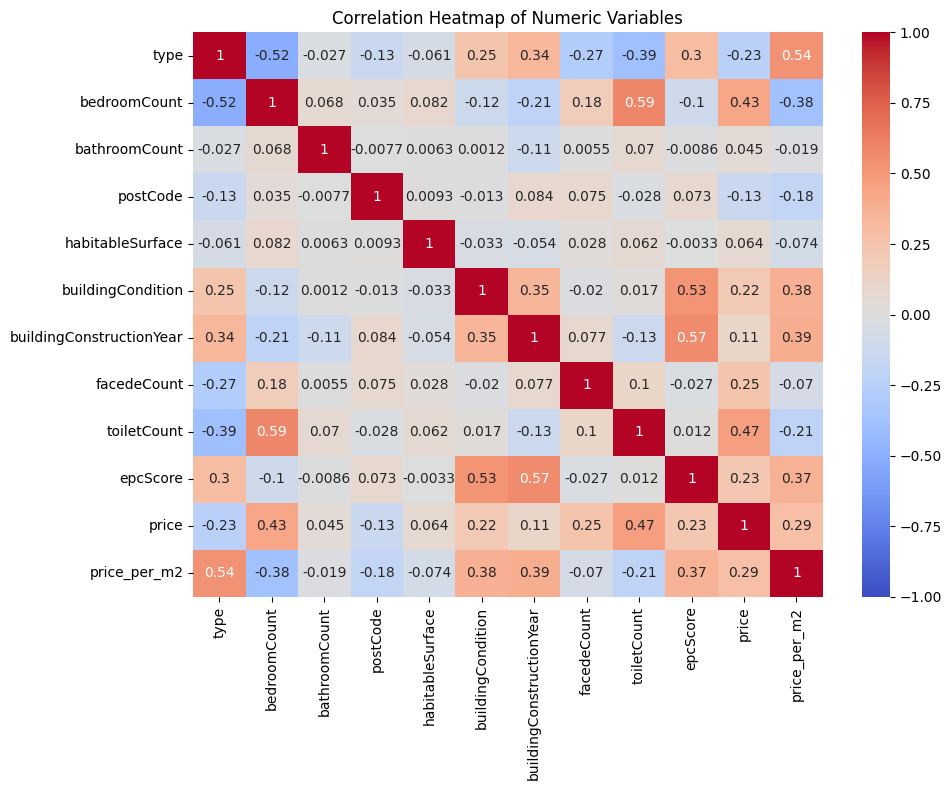

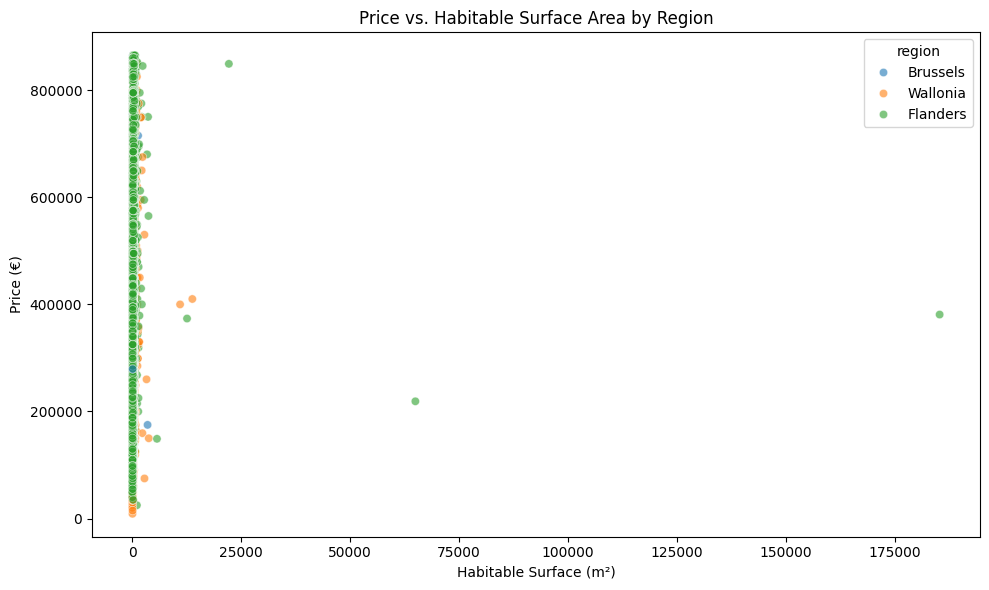

/var/folders/yp/grpj3l556fl4nly4zbgbvzb80000gn/T/ipykernel_95549/1833030899.py:103: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_price_m2.index, y=avg_price_m2.values, palette="viridis")


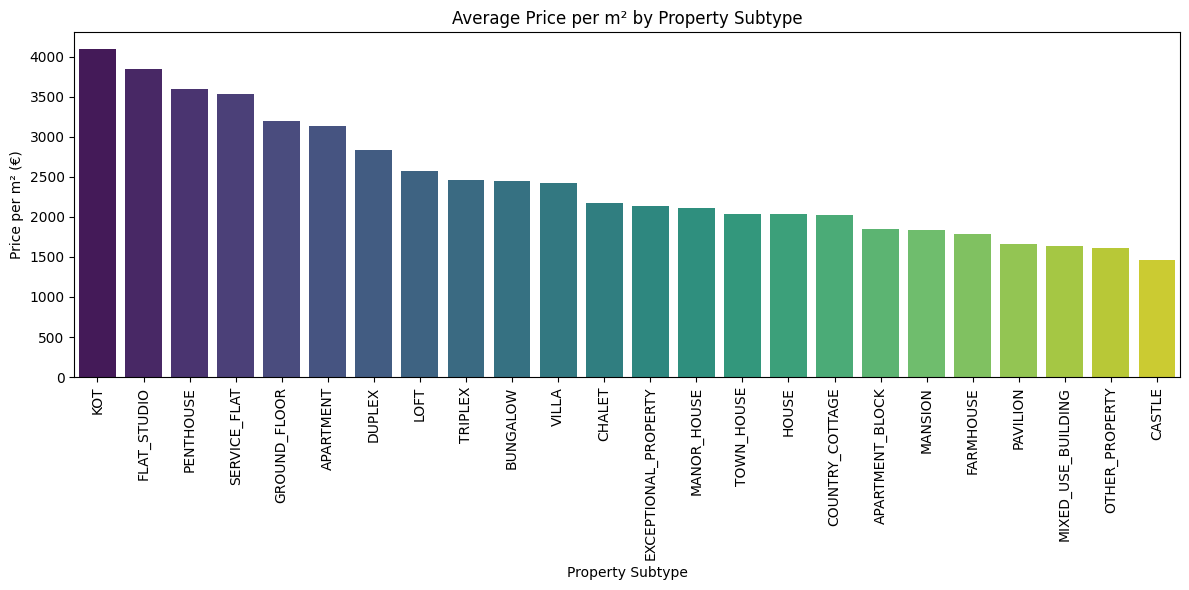

/var/folders/yp/grpj3l556fl4nly4zbgbvzb80000gn/T/ipykernel_95549/1833030899.py:117: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x='type', palette='Set2')  # Set2 gives pastel colors


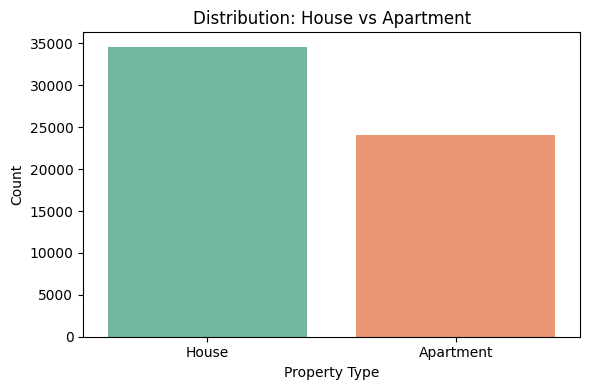

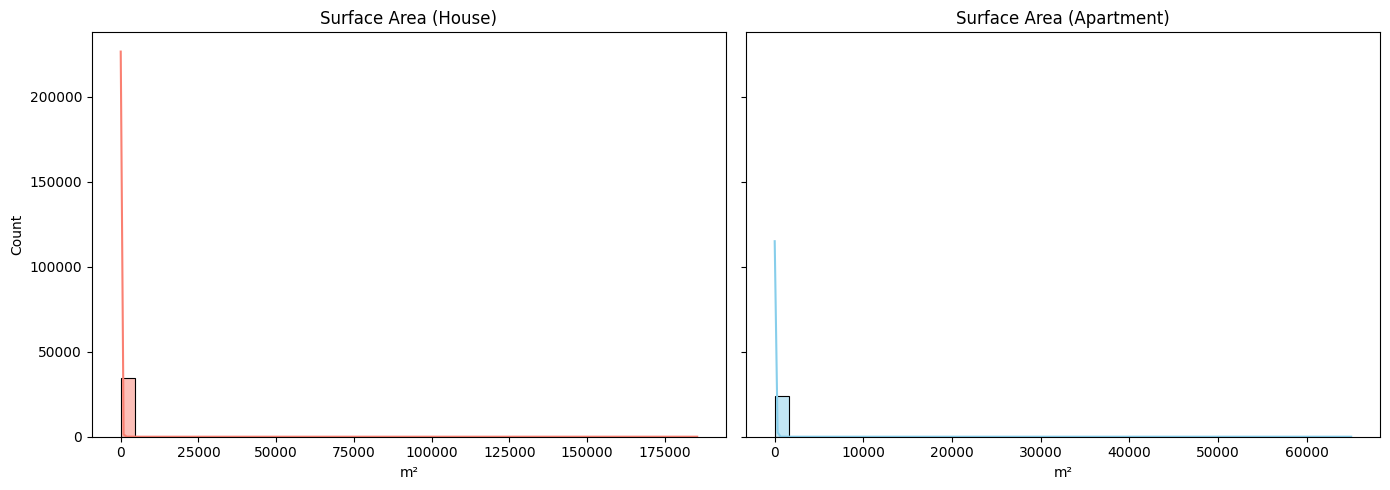

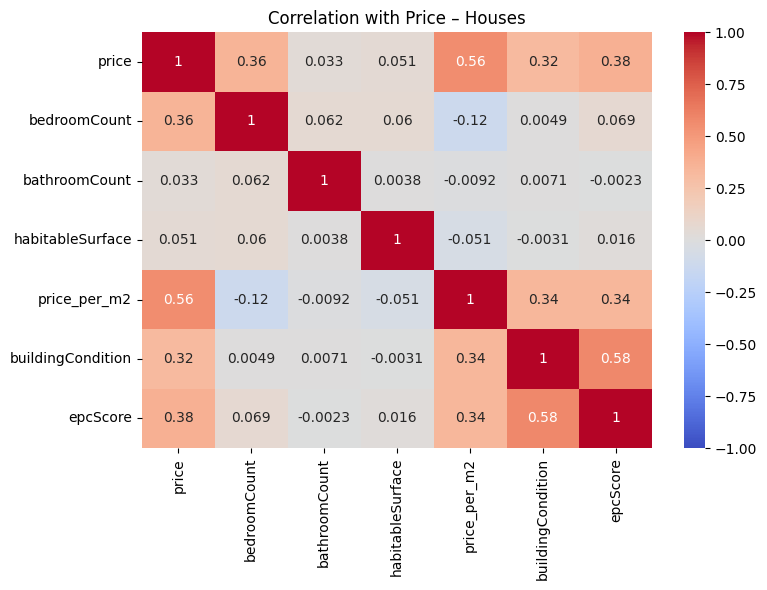

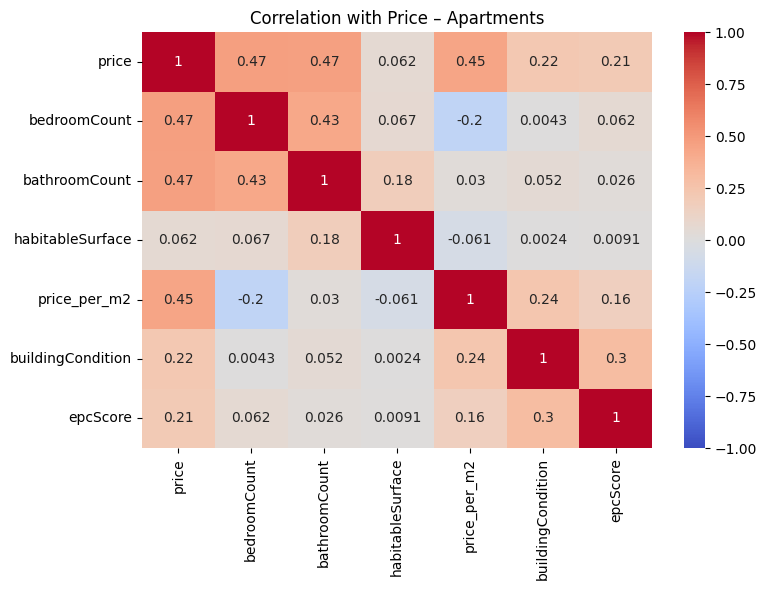

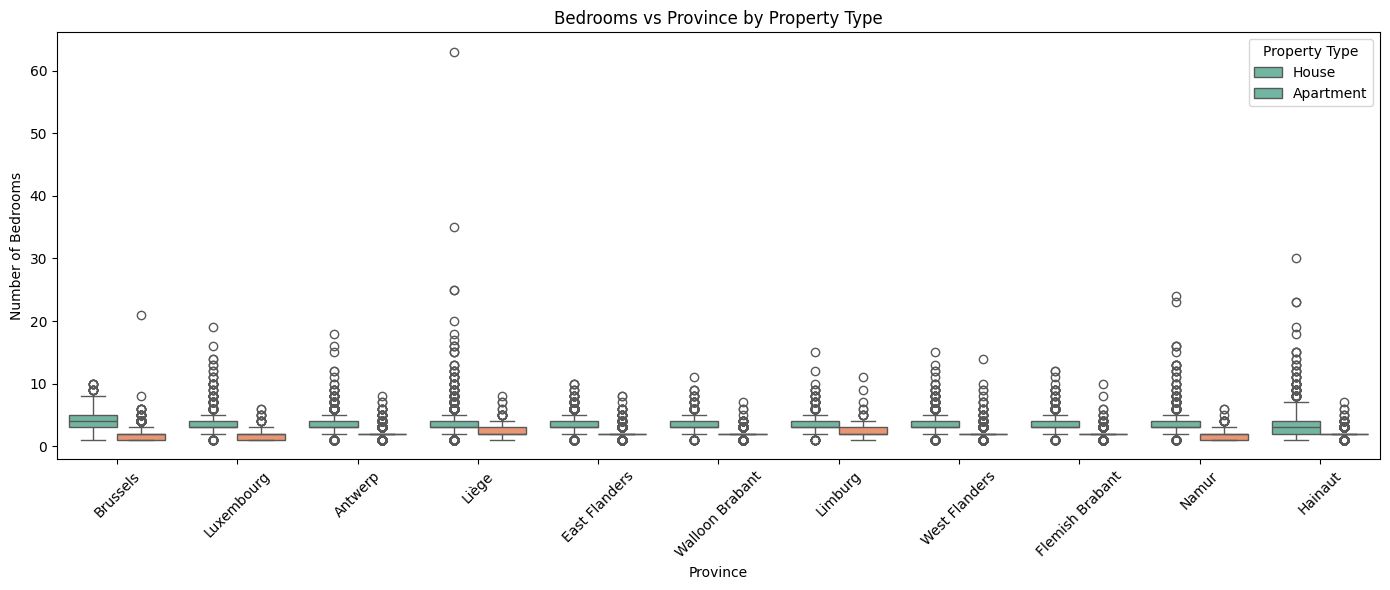

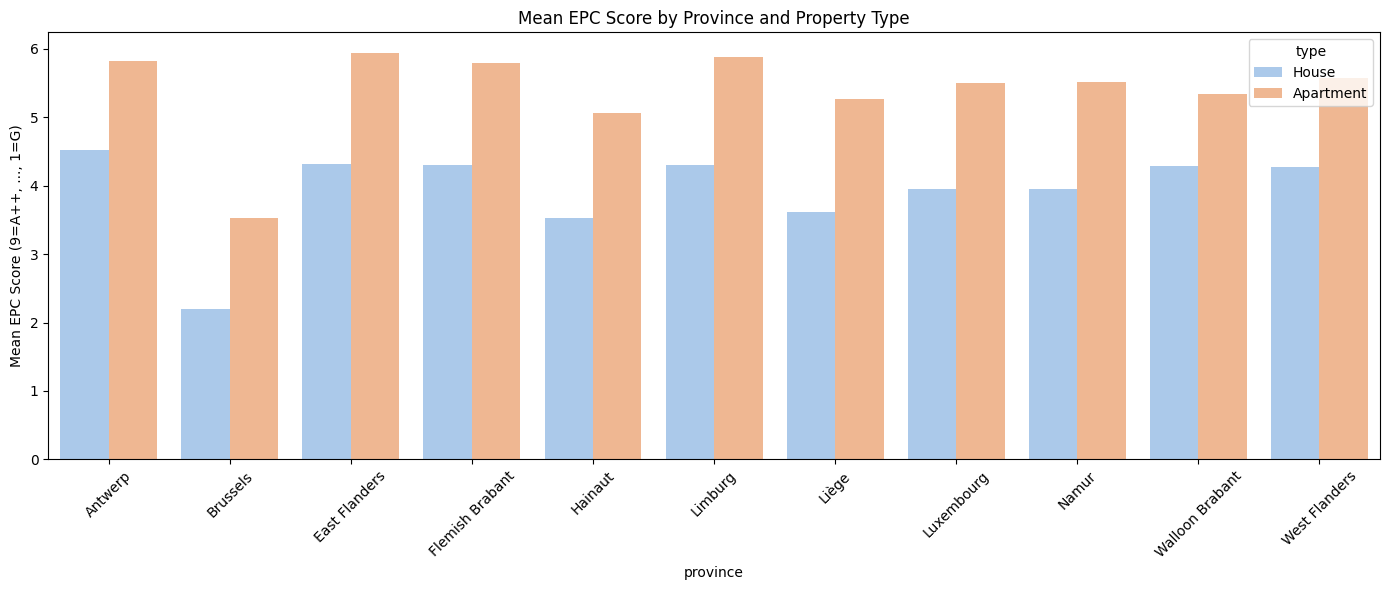

/var/folders/yp/grpj3l556fl4nly4zbgbvzb80000gn/T/ipykernel_95549/1833030899.py:220: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


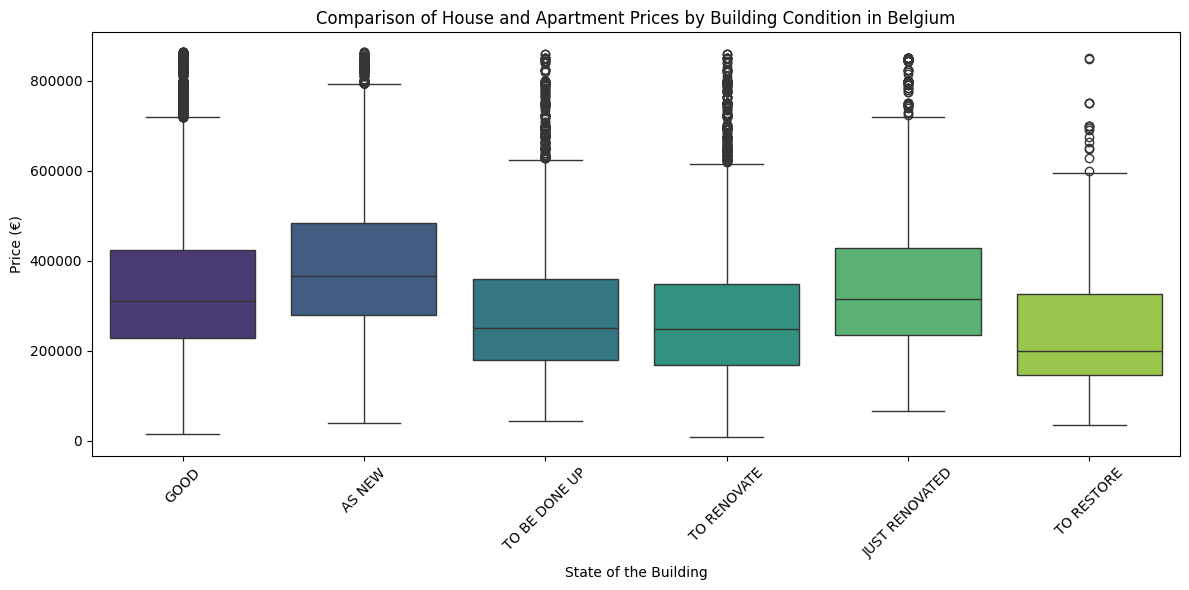

In [5]:
# === IMPORT LIBRARIES ===
# These are essential libraries for data manipulation, plotting and modeling
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from tqdm import tqdm
import time
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
#First look after first cleaning
import sys
print(sys.executable)

import pandas as pd
print(pd.__version__)

# === LOAD CLEANED DATA ===
# This dataset was cleaned and saved by clean.py. No further cleaning needed here.
file_path = 'data/cleaned/immoweb-dataset_cleaned_mvg.csv'
data = pd.read_csv(file_path)
data = pd.read_csv("data/cleaned/immoweb-dataset_cleaned_mvg.csv")
print(f"✅ Data loaded. Rows: {len(data)}, Columns: {data.shape[1]}")

# === Get to know and visualize our data ===
# Data Overview
print("Data Overview:")
print(f"Rows: {data.shape[0]}")
print(f"Columns: {data.shape[1]}")
print("\nData types:")
print(data.dtypes)

# Check for missing values
missing_values = data.isnull().sum()
print("\nMissing Values:")
print(missing_values)

# Check for duplicates
duplicates = data.duplicated().sum()
print(f"\nDuplicates: {duplicates}")

# Display basic info about the dataset
print("\nBasic Information:")
print(data.info())

# Show the first few rows of the dataset to inspect the data
print("\nFirst few rows of the dataset:")
print(data.head())

# Count the number of "Unknown" values in the 'Region' column
unknown_count = data[data['region'] == 'Unknown'].shape[0]
print(f"Number of 'Unknown' values in the 'Region' column: {unknown_count}")

# === EXPLORATORY ANALYSIS: NEW VISUALIZATIONS ===

# 1. Distribution of Property Prices (below €1.5M)
# This helps identify the shape of the price distribution and presence of outliers
plt.figure(figsize=(10, 6))
sns.histplot(data[data['price'] < 1_500_000]['price'], bins=50, kde=True, color='skyblue')
plt.title("Distribution of Property Prices (< €1.5M)")
plt.xlabel("Price (€)")
plt.ylabel("Number of Properties")
plt.tight_layout()
plt.show()

# 2. Boxplot of Price per m² by Region
# Boxplots are great to compare central tendency and spread across categories
plt.figure(figsize=(8, 6))
sns.boxplot(data=data, x='region', y='price_per_m2', palette='pastel')
plt.title("Price per m² by Region")
plt.xlabel("Region")
plt.ylabel("Price per m² (€)")
plt.tight_layout()
plt.show()

# 3. Heatmap of Correlations Between Numeric Features
# Helps reveal which variables have a strong relationship, useful for feature selection
plt.figure(figsize=(10, 8))
sns.heatmap(data.select_dtypes(include='number').corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Heatmap of Numeric Variables")
plt.tight_layout()
plt.show()

# 4. Price vs. Surface Area by Region
# A colored scatterplot shows if the size–price relationship differs per region
plt.figure(figsize=(10, 6))
sns.scatterplot(data=data, x='habitableSurface', y='price', hue='region', alpha=0.6)
plt.title("Price vs. Habitable Surface Area by Region")
plt.xlabel("Habitable Surface (m²)")
plt.ylabel("Price (€)")
plt.tight_layout()
plt.show()

# 5. Average Price per m² by Property Subtype
# Shows which property subtypes tend to be more expensive per m²
avg_price_m2 = data.groupby("subtype")["price_per_m2"].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=avg_price_m2.index, y=avg_price_m2.values, palette="viridis")
plt.xticks(rotation=90)
plt.title("Average Price per m² by Property Subtype")
plt.ylabel("Price per m² (€)")
plt.xlabel("Property Subtype")
plt.tight_layout()
plt.show()


# 6. Distribution of Houses and Apartments
# Purpose: Understand the relative number of listings per property type
# 'countplot' shows how many entries exist for each category in 'type'
# Insight: Helps assess class imbalance, useful for modeling or pricing trends.
plt.figure(figsize=(6, 4))
sns.countplot(data=data, x='type', palette='Set2')  # Set2 gives pastel colors
plt.title('Distribution: House vs Apartment')
plt.xticks(ticks=[0, 1], labels=['House', 'Apartment'])  # Map encoded type values to labels
plt.xlabel('Property Type')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


# 7. Surface Area Distribution by Property Type
# Purpose: Compare typical surface areas for houses vs apartments
# 'histplot' visualizes distributions with optional KDE (smooth curve)
# Insight: Confirms that houses generally have larger surfaces; KDE helps spot multimodal patterns.
fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

sns.histplot(data[data['type'] == 0]['habitableSurface'], bins=40, kde=True, ax=axs[0], color='salmon')
axs[0].set_title('Surface Area (House)')
axs[0].set_xlabel('m²')

sns.histplot(data[data['type'] == 1]['habitableSurface'], bins=40, kde=True, ax=axs[1], color='skyblue')
axs[1].set_title('Surface Area (Apartment)')
axs[1].set_xlabel('m²')

plt.tight_layout()
plt.show()


# 8. Correlation Heatmap (with Price)
# Purpose: Understand how numeric variables relate to price
# 'heatmap' visualizes correlations between -1 and 1; stronger colors = stronger relationships
# Insight: Reveals strongest predictors of price; useful for feature selection.
# 'annot=True' shows numeric values; 'coolwarm' color scale distinguishes + vs - correlation
selected_cols = ['price', 'bedroomCount', 'bathroomCount', 'habitableSurface', 'price_per_m2', 'buildingCondition', 'epcScore']
corr = data[selected_cols].corr()
# CORRELATION FOR HOUSES
house_data = data[data['type'] == 0]  # Filter for houses
corr_house = house_data[selected_cols].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_house, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation with Price – Houses')
plt.tight_layout()
plt.show()
# CORRELATION FOR APARTMENTS
apartment_data = data[data['type'] == 1]  # Filter for apartments
corr_apartment = apartment_data[selected_cols].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_apartment, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation with Price – Apartments')
plt.tight_layout()
plt.show()


# 9. Bedrooms vs Province by Property Type
# Purpose: Show how number of bedrooms varies by province and type
# 'boxplot' shows distribution (median, quartiles, outliers) for each group
# Insight: Detects regional trends in bedroom size; useful for regional modeling or segmentation
plt.figure(figsize=(14, 6))
sns.boxplot(data=data, x='province', y='bedroomCount', hue='type', palette='Set2')
plt.title('Bedrooms vs Province by Property Type')
plt.xticks(rotation=45)  # Rotate province names for readability
plt.xlabel('Province')
plt.ylabel('Number of Bedrooms')
plt.legend(title='Property Type', labels=['House', 'Apartment'])
plt.tight_layout()
plt.show()


# 10. Mean EPC Score by Province and Property Type
# Purpose: Assess energy efficiency patterns across regions and property types
# Higher EPC scores (closer to 9) mean more energy-efficient properties
# Insight: Useful for evaluating where more energy-efficient housing exists.
# May reflect newer building stock, renovations, or stricter local regulations.
epc_grouped = data.groupby(['province', 'type'])['epcScore'].mean().reset_index()
epc_grouped['type'] = epc_grouped['type'].map({0: 'House', 1: 'Apartment'})

plt.figure(figsize=(14, 6))
sns.barplot(data=epc_grouped, x='province', y='epcScore', hue='type', palette='pastel')
plt.title('Mean EPC Score by Province and Property Type')
plt.xticks(rotation=45)
plt.ylabel('Mean EPC Score (9=A++, ..., 1=G)')
plt.tight_layout()
plt.show()

# 11. Price vs Building Condition
# You can clearly see that properties in better condition (JUST RENOVATED or AS NEW) command higher median prices and narrower spreads.
# The spread of prices increases as condition worsens (e.g. TO RESTORE).
# Outliers are visible as dots outside the whiskers.

# Map numerical buildingCondition values back to readable labels for better plot readability
# These labels reflect the original condition categories in the raw dataset
condition_labels = {
    6: "JUST RENOVATED", 
    5: "AS NEW", 
    4: "GOOD",
    3: "TO BE DONE UP", 
    2: "TO RENOVATE", 
    1: "TO RESTORE"
}
data['buildingConditionLabel'] = data['buildingCondition'].map(condition_labels)

# 📦 Create a boxplot showing the distribution of price for each building condition
plt.figure(figsize=(12, 6))  # Sets the size of the plot in inches (width, height)

sns.boxplot(
    x='buildingConditionLabel',  # Categorical variable on the x-axis
    y='price',                   # Numerical variable on the y-axis
    data=data,                   # Data source (our cleaned dataframe)
    palette='viridis'           # Color palette for consistent styling
)

plt.xticks(rotation=45)  # Rotates x-axis labels for better readability
plt.title("Comparison of House and Apartment Prices by Building Condition in Belgium")
plt.xlabel("State of the Building")
plt.ylabel("Price (€)")
plt.tight_layout()  # Automatically adjusts spacing to prevent label cut-off
plt.show()



NameError: name 'data' is not defined

What have we learned from the analysis so far (up to WIP)

📊 1. Distribution of Property Prices (< €1.5M)
Visual: Histogram + KDE plot
Insights:

Most properties are priced between €150k and €400k.

The distribution is right-skewed, meaning there are many cheaper properties and fewer high-end ones.

The KDE curve shows a peak (mode) around €275k, followed by a long tail of more expensive properties.

Helps identify outliers above €1.5M which you can choose to exclude in modeling.

✅ What to do with this:

Consider log-transforming price if you're applying linear models.

You could filter out the top 1% most expensive properties to reduce skew.

🏙️ 2. Boxplot: Price per m² by Region
Visual: Boxplot by region (Brussels, Wallonia, Flanders)
Insights:

Brussels has the highest price per m² on average and also the widest spread (variability).

Flanders is more expensive than Wallonia on a per m² basis.

All regions show clear outliers, with some properties priced >€20,000/m².

✅ What to do with this:

Region clearly matters for price → keep region in your model.

Consider building region-specific models if performance differs.

🔥 3. Correlation Heatmap of Numeric Variables
Visual: Correlation matrix of selected features
Insights:

price_per_m2 is strongly positively correlated with epcScore, buildingCondition, and buildingConstructionYear.

type and bedroomCount show moderate negative correlation with price per m².

epcScore and buildingCondition are themselves moderately correlated (as newer homes tend to be better insulated).

✅ What to do with this:

These insights validate that energy efficiency and building quality affect value.

This can help with feature selection or importance interpretation.

📏 4. Scatterplot: Price vs Habitable Surface Area by Region
Visual: Scatterplot coloured by region
Insights:

General positive relationship: more surface → higher price.

Outliers (some very large properties or misreported surface values).

Region is again a clear differentiator, especially in high-priced brackets.

✅ What to do with this:

Possibly cap habitable surface at 1,000–1,500 m² for modeling.

Highlight the potential impact of misreported data or very unique properties.

🏠 5. Barplot: Average Price per m² by Property Subtype
Visual: Horizontal barplot by subtype
Insights:

Kots, Penthouses, and Studios dominate the top of the list — these have very high price per m² due to their small size.

Villas, Duplexes, Houses lie around the mid-range.

Mixed-use buildings, Pavilions and other atypical properties are at the bottom.

✅ What to do with this:

subtype is a highly predictive feature.

You might consider grouping similar subtypes for simplification (e.g., "compact units", "family homes", etc.).


Correlation Heatmap – Houses vs Price
🧭 What it shows:
The strength and direction of the relationship between numeric features and the price of houses.

📌 Key Insights:

price_per_m2 has the strongest correlation with price (r = 0.64), meaning it’s a good proxy.

Surprisingly, habitableSurface has very low correlation with price for houses (≈0.10). This suggests that house price depends more on price per m² or location than just surface.

buildingCondition and epcScore have modest positive correlation, hinting at some value placed on building quality and energy efficiency.

2. Correlation Heatmap – Apartments vs Price
🧭 What it shows:
Same as above, but limited to apartments.

📌 Key Insights:

price_per_m2 has even stronger correlation with price for apartments (r = 0.74), making it a key driver.

bathroomCount and bedroomCount show a stronger relationship with price than in houses, which makes sense: extra rooms in apartments often command a premium.

buildingCondition and epcScore again show some correlation, confirming their relevance in apartment valuation too.

3. Boxplot – Bedrooms vs Province by Property Type
🧭 What it shows:
The distribution of bedroom counts across provinces, separated for houses and apartments.

📌 Key Insights:

Houses consistently have more bedrooms than apartments across all provinces (as expected).

Some provinces like Brussels and Hainaut show more outliers (very large properties).

Helps identify regions with generally larger homes (e.g. Wallonia seems to allow bigger houses).

4. Barplot – Mean EPC Score by Province and Type
🧭 What it shows:
Average EPC score (energy performance) by province and property type.

📌 Key Insights:

Apartments generally score better (higher EPC scores) than houses across all provinces.

Brussels houses appear to be the least energy efficient.

This may be due to newer apartment buildings, stricter rules in multi-units, or less insulation in old houses.

5. Barplot – Average Price per m² by Subtype
🧭 What it shows:
The average price per square meter for each property subtype.

📌 Key Insights:

Student housing (KOT) and penthouses are the most expensive per m² – likely due to premium location or small size with high amenities.

Houses, villas, farmhouses, and castles are cheaper per m² – indicating economies of scale or location far from city centres.

Useful for targeting niche investment (e.g., service flats, lofts) or predicting prices by subtype.

Summary Takeaway:
Property subtype, location (region/province), and price per m² are dominant factors.

Apartments are more predictable and price-driven, while houses have more variation.

Energy efficiency and condition matter, but less than size and type.

These visualisations are essential for exploratory analysis and help design a smarter prediction model (e.g. using subtype, region, and price/m² as key features).










In [ ]:
# REMOVE OUTLIERS
def remove_outliers_iqr(df, columns):
    df_filtered = df.copy()
    for col in columns:
        Q1 = df_filtered[col].quantile(0.25)
        Q3 = df_filtered[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        
        # Print stats
        print(f"\n📊 Outlier analysis for '{col}':")
        print(f"  Q1 (25th percentile): {Q1:,.2f}")
        print(f"  Q3 (75th percentile): {Q3:,.2f}")
        print(f"  IQR: {IQR:,.2f}")
        print(f"  Outlier threshold: < {lower:,.2f} or > {upper:,.2f}")

        original_len = len(df_filtered)
        outlier_count = df_filtered[(df_filtered[col] < lower) | (df_filtered[col] > upper)].shape[0]
        pct_removed = 100 * outlier_count / original_len
        print(f"  Outliers to remove: {outlier_count} ({pct_removed:.2f}%)")

        # PLOT before removal
        plt.figure(figsize=(10, 4))
        sns.boxplot(x=df_filtered[col])
        plt.title(f"Before: Outliers in {col}")
        plt.xlabel(col)
        plt.tight_layout()
        plt.show()

        # Remove outliers
        df_filtered = df_filtered[(df_filtered[col] >= lower) & (df_filtered[col] <= upper)]

        # PLOT after removal
        plt.figure(figsize=(10, 4))
        sns.boxplot(x=df_filtered[col])
        plt.title(f"After: Outliers removed from {col}")
        plt.xlabel(col)
        plt.tight_layout()
        plt.show()

    return df_filtered

# Columns to check for outliers
columns_to_filter = ['price', 'price_per_m2', 'habitableSurface', 'bedroomCount', 'bathroomCount']
# Apply outlier removal
df_no_outliers = remove_outliers_iqr(df, columns_to_filter)


In [ ]:
# 12. Geographic Distribution of Properties by Province
# This plot requires latitude and longitude columns to be present in the dataset
# It shows where properties are located in Belgium and how they are distributed by province
# Each dot represents a property; color indicates its province.
# Densely packed regions (e.g. around Brussels or Antwerp) show urban clusters.
# The spatial pattern helps us understand where the bulk of listings are, and how geographic location relates to pricing or property types.

# Combine locality + province into a full location string
data["full_location"] = data["locality"].astype(str) + ", " + data["province"].astype(str) + ", Belgium"

# Set up the geocoder with a delay between calls to respect Nominatim's usage policy
geolocator = Nominatim(user_agent="immoeliza-app")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

# Prepare cache dict to avoid duplicate geocoding
location_cache = {}

# Setup progress bar for geocoding
tqdm.pandas()

def get_coordinates(location):
    if location in location_cache:
        return location_cache[location]
    try:
        loc = geocode(location)
        if loc:
            coords = (loc.latitude, loc.longitude)
        else:
            coords = (None, None)
    except:
        coords = (None, None)
    location_cache[location] = coords
    return coords

# Apply geocoding with progress bar
print("🔍 Geocoding locations... this may take a few minutes")
data[['latitude', 'longitude']] = data['full_location'].progress_apply(lambda x: pd.Series(get_coordinates(x)))

# Save updated CSV
output_path = "data/cleaned/immoweb-dataset_cleaned_mvg.csv"
data.to_csv(output_path, index=False)
print(f"✅ Done! Coordinates added and saved to: {output_path}")

# It shows where properties are located in Belgium and how they are distributed by province
if 'latitude' in data.columns and 'longitude' in data.columns:
    plt.figure(figsize=(10, 8))  # Bigger canvas for a map-like plot

    sns.scatterplot(
        x='longitude',           # Horizontal axis: longitude (east-west position)
        y='latitude',            # Vertical axis: latitude (north-south position)
        hue='province',          # Color by province name to distinguish clusters
        data=data,
        palette='Spectral',      # 'Spectral' palette provides diverse and contrasting colors
        s=10,                    # Size of each point (in points^2); small enough to show density
        alpha=0.7,               # Transparency of points (0 = invisible, 1 = opaque)
        edgecolor=None           # No edge color to keep it clean
    )

    plt.title("Distribution of Houses and Apartments by Province in Belgium")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.legend(title='Province', bbox_to_anchor=(1.05, 1), loc='upper left')  # Place legend outside plot
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Columns 'latitude' and 'longitude' are required for this plot.")

# Work in progress - Modelling for ML
# === TRAIN-TEST SPLIT ===
# We split the data into training and test sets so that the model can learn on one part
# and be evaluated on unseen data.
X = data.drop(columns="price")
y = data["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"✅ Training set: {X_train.shape}, Test set: {X_test.shape}")

# === RANDOM FOREST MODEL ===
# Random Forest is a robust regression model that works well with both numerical and categorical (encoded) data.
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
print("🌲 Random Forest model trained.")

# === FEATURE IMPORTANCE ===
# This plot helps us understand which features are most important to the model’s predictions.
importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
importances.head(10).plot(kind="barh", color='teal')
plt.title("Top 10 Feature Importances")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# === MODEL PERFORMANCE ===
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
print("📊 Model Performance:")
print(f"MAE : {mae:,.0f} €")
print(f"RMSE: {rmse:,.0f} €")
print(f"R²  : {r2:.3f}")

# === PREDICTED VS ACTUAL ===
# This scatter plot lets us check how close our predictions are to actual values.
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.title("Predicted vs Actual Prices")
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.tight_layout()
plt.show()

# === MISSING VALUES PLOT ===
# Although cleaned, this plot is good for exploratory completeness.
missing = data.isnull().mean() * 100
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=missing.index, y=missing.values, palette="Blues_r")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.ylabel('Missing Values (%)')
plt.title('Missing Values per Column')
plt.tight_layout()
plt.show()

# === PROPERTY TYPE DISTRIBUTION ===
if 'type' in data.columns:
    counts = data['type'].value_counts().sort_index()
    labels = ['House', 'Apartment']
    plt.figure()
    plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=90)
    plt.title('Property Type Distribution')
    plt.tight_layout()
    plt.show()

# === CORRELATION HEATMAP ===
# Shows linear relationships between features. Useful for feature selection or multicollinearity checks.
top_corr_cols = ['price', 'habitableSurface', 'bedroomCount', 'bathroomCount', 'buildingCondition', 'epcScore']
plt.figure(figsize=(8, 6))
sns.heatmap(data[top_corr_cols].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Key Features')
plt.tight_layout()
plt.show()

# === SCATTER PLOTS VS PRICE ===
# Visual inspection of how some numeric features relate to price (check linearity, patterns)
top_vars = ['habitableSurface', 'bedroomCount', 'bathroomCount']
for var in top_vars:
    plt.figure(figsize=(8, 5))
    sns.regplot(x=var, y='price', data=data, scatter_kws={'s': 10}, line_kws={'color': 'red'})
    plt.title(f'Price vs {var}')
    plt.xlabel(var)
    plt.ylabel('Price')
    plt.tight_layout()
    plt.show()

# === HISTOGRAM OF SURFACE AREAS ===
# Shows how properties are distributed by size, filters out extreme outliers for better view.
plt.figure(figsize=(10, 5))
sns.histplot(data[data['habitableSurface'] < 800]['habitableSurface'], bins=40, kde=True, color='green')
plt.title('Distribution of Habitable Surface (<800 m²)')
plt.xlabel('Habitable Surface (m²)')
plt.ylabel('Number of Properties')
plt.tight_layout()
plt.show()

# === PRICE PER M² BY REGION AND TYPE ===
# Tells us which regions/property types are most expensive per m². Key for investment insights.
if 'region_Flanders' in data.columns or 'region' in data.columns:
    df_copy = data.copy()
    if 'region' not in df_copy.columns:
        def reverse_region(row):
            if row.get('region_Flanders') == 1:
                return 'Flanders'
            elif row.get('region_Wallonia') == 1:
                return 'Wallonia'
            else:
                return 'Brussels'
        df_copy['region'] = df_copy.apply(reverse_region, axis=1)

    df_filtered = df_copy[(df_copy['price'] > 100000) & (df_copy['price'] < 1000000)]
    median_prices = df_filtered.groupby(['region', 'type'])['price_per_m2'].median().reset_index()

    plot = sns.catplot(x="region", y="price_per_m2", hue="type", kind="bar", data=median_prices, palette="Set2")
    plt.title("Median Price per m² by Region and Property Type")
    plot._legend.set_title("Property Type")
    plot._legend.texts[0].set_text("Apartment")
    plot._legend.texts[1].set_text("House")
    plt.tight_layout()
    plt.show()


✅ Training set: (30967, 16), Test set: (7742, 16)


ValueError: could not convert string to float: 'APARTMENT'